# Trabajo práctico N°2
## Detectando lugares del mundo.

Estos son datos de imágenes de escenas naturales de todo el mundo, contienen alrededor de 25.000 imágenes de tamaño 150x150
Las categorias en las que se busca entrenar el modelo son las siguientes:
* Buildings / Edificios
* Forest / Bosque
* Glacier / Glaciar
* Mountain / Montaña
* Sea / Mar
* Street / Calle

In [1]:
try:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf
    import warnings
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Conv2D, Flatten
    from tensorflow.keras.callbacks import Callback
    from tensorflow.keras.applications import VGG19, ResNet101
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    from tensorflow.keras.models import Model
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.optimizers import Adam

    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


In [2]:
img_folder_train = r"C:\Users\Joaco\Documents\ucse\dataset\train"
img_folder_test = r"C:\Users\Joaco\Documents\ucse\dataset\test"

# Categorias propuestas
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df = pd.DataFrame(columns=['filename', 'category'])

# Recorremos cada subcarpeta
for category in categories:
    category_path = os.path.join(img_folder_train, category) 
    for img_file in os.listdir(category_path):  # Por cada archivo en la subcarpeta
        if img_file.endswith(".jpg"): 
            img_path = os.path.join(category_path, img_file)  
            temp_df = pd.DataFrame({'filename': [img_file], 'category': [category]})
            # Usamos pd.concat para agregar al DataFrame principal
            df = pd.concat([df, temp_df], ignore_index=True)

# 1. Análisis exploratorio sobre el conjunto de datos.
* Volumetría de los datos: 14043 imágenes.

In [3]:
df.shape

(14034, 2)

* Estructura y tipo de las imágenes: 150x150 píxeles y están en formato .jpg

In [4]:
df.info

<bound method DataFrame.info of         filename   category
0          0.jpg  buildings
1      10006.jpg  buildings
2       1001.jpg  buildings
3      10014.jpg  buildings
4      10018.jpg  buildings
...          ...        ...
14029   9961.jpg     street
14030   9967.jpg     street
14031   9978.jpg     street
14032   9989.jpg     street
14033    999.jpg     street

[14034 rows x 2 columns]>

* Distribución de la variable a predecir: 'category'

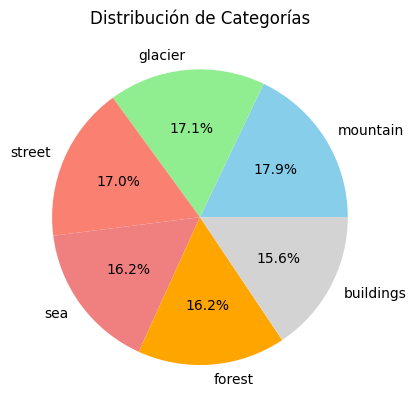

In [3]:
# Porcentaje de cada categoría
category_percent = df['category'].value_counts(normalize=True) * 100
category_percent.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'orange', 'lightgrey'])
plt.title('Distribución de Categorías')
plt.ylabel('')
plt.show()

La distribución de las categorías en el dataset muestra un equilibrio relativamente bueno entre las diferentes clases. Cada categoría presenta una proporción similar de imágenes, lo que sugiere que el modelo de aprendizaje automático tendrá suficiente información de cada clase para aprender a diferenciarlas.

Este balance en la distribución de clases es beneficioso, ya que ayuda a prevenir problemas de sobreajuste en el modelo y permite una mejor generalización. Sin embargo, se debe monitorear el rendimiento del modelo para asegurarse de que todas las categorías sean representadas adecuadamente durante el entrenamiento.

# 2. Modelado
### Preparación de datos

In [3]:
# Configuramos el generador para entrenamiento con aumentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Generador para el conjunto de validación (sin aumentación)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Cargamos las imágenes en los generadores
# Subconjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    img_folder_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

# Subconjunto de validación
validation_generator = validation_datagen.flow_from_directory(
    img_folder_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [4]:
train_counts = pd.Series(train_generator.classes).value_counts()
val_counts = pd.Series(validation_generator.classes).value_counts()

print("Distribución en el conjunto de entrenamiento:")
print(train_counts)

print("\nDistribución en el conjunto de validación:")
print(val_counts)

Distribución en el conjunto de entrenamiento:
3    2010
2    1924
5    1906
4    1820
1    1817
0    1753
Name: count, dtype: int64

Distribución en el conjunto de validación:
3    502
2    480
5    476
1    454
4    454
0    438
Name: count, dtype: int64


In [11]:
# Variables globales
input_shape=(150, 150, 3)
SIZE = 150

# Funcion para plotear resultados
def plot_history_result(history):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

# Funcion para descargar en formato .csv los resultados obtenidos
def get_csv(directory, model, name_model):
    results = [] 
    images = [] 

    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)

        if image_name.endswith(".jpg"):
            image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
            images.append(image_array)

    inputs = np.array(images) / 255.0

    predictions = model.predict(inputs)

    for i, image_name in enumerate(os.listdir(directory)):
        if image_name.endswith(".jpg"):
            predicted_class = categories[np.argmax(predictions[i])]
            results.append([image_name, predicted_class])

    df = pd.DataFrame(results, columns=["ID", "Label"])
    df.to_csv(name_model + ".csv", index=False)
    print("Archivo '" + name_model + ".csv' guardado en raiz")

# Funcion para imprimir imagenes
def sample_images(dataset, titulo):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titulo) if i == 1 else plt.title('')
        plt.axis("off")

## Imágenes para entrenar:

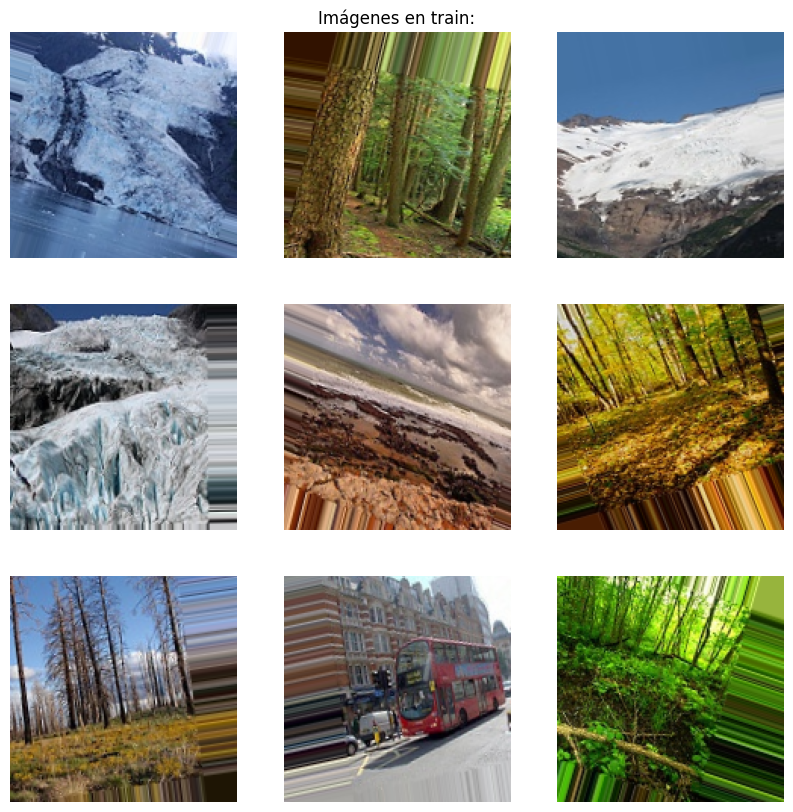

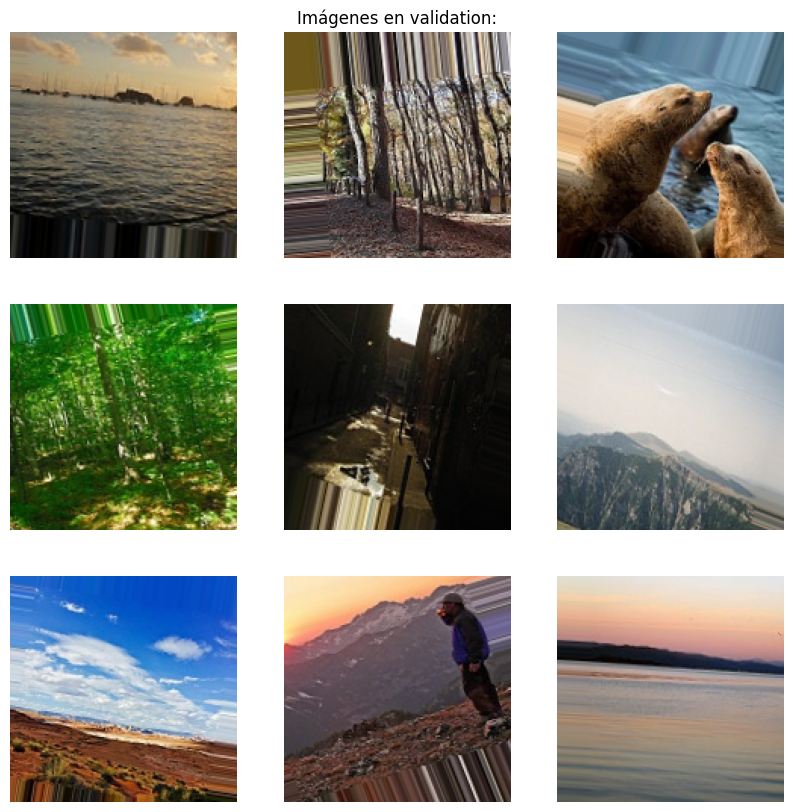

In [12]:
sample_images(train_generator, 'Imágenes en train:')
sample_images(train_generator, 'Imágenes en validation:')

# CNN (Convolutional Neural Network)
#### Convolutional_filter: 32, Convolutional_filter: 64,Convolutional_filter: 128, Activation: 'relu'

In [6]:
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history_CNN = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 252s 719ms/step - loss: 3.7484 - accuracy: 0.4684 - val_loss: 1.6725 - val_accuracy: 0.4616
Epoch 2/10
350/350 [==============================] - 256s 731ms/step - loss: 1.2381 - accuracy: 0.5411 - val_loss: 0.9854 - val_accuracy: 0.6634
Epoch 3/10
350/350 [==============================] - 248s 708ms/step - loss: 1.0882 - accuracy: 0.5917 - val_loss: 2.1135 - val_accuracy: 0.5449
Epoch 4/10
350/350 [==============================] - 262s 749ms/step - loss: 1.0912 - accuracy: 0.5971 - val_loss: 0.8765 - val_accuracy: 0.7004
Epoch 5/10
350/350 [==============================] - 252s 719ms/step - loss: 1.0127 - accuracy: 0.6358 - val_loss: 0.7658 - val_accuracy: 0.7371
Epoch 6/10
350/350 [==============================] - 265s 756ms/step - loss: 0.9782 - accuracy: 0.6466 - val_loss: 0.8589 - val_accuracy: 0.7008
Epoch 7/10
350/350 [==============================] - 255s 729ms/step - loss: 0.9389 - accuracy: 0.6612 - val_loss: 0.9174 -

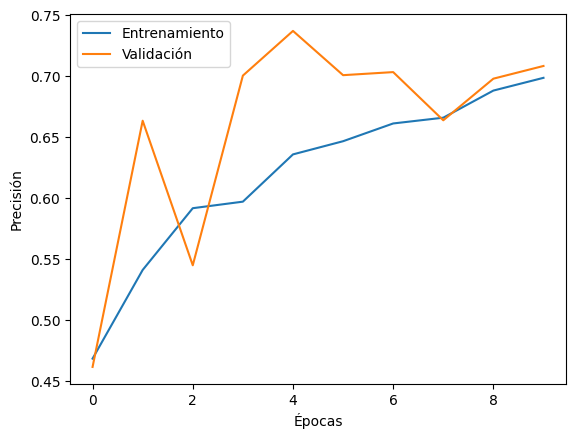

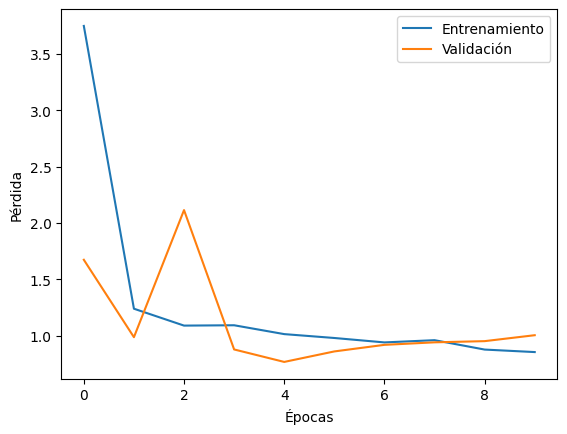

In [12]:
# Graficamos la precisión de CNN
plot_history_result(history_CNN)

#### Observaciones:
* **Entrenamiento:** Observando el gráfico podemos ver que el modelo muestra una mejora en el entrenamiento, incrementando la métrica accuracy = 0.4684 en la primera época a 0.6986 en la última. Esto indica que fue aprendiendo a categorizar las imagenes  en el conjunto de entrenamiento de una mejor manera.

* **En el conjunto de validación:** La precisión en el conjunto de validación alcanzó su punto más alto en la época 5 con un accuracy de 0.7371, aunque el gráfico presenta algunos picos anómalos. Al mismo tiempo, la pérdida de validación no sigue una tendencia clara de descenso, en las últimas épocas muestra un ascenso y termina siendo mayor a los valores registrados en train.

* **Posible sobreajuste:** La diferencia entre la pérdida en train y la de validation en las últimas épocas sugiere que el modelo podría estar ajustándose demasiado a los datos y no generalizando.

# MLP (Multi-Layer Perceptron)
#### Dense: 500, Dropout: 0.25

In [13]:
modelMLP = Sequential([
    Input(input_shape),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.25),
    Dense(len(categories), activation='softmax'),
])

modelMLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history_MLP = modelMLP.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/10
351/351 [==============================] - 66s 188ms/step - loss: 5.3305 - accuracy: 0.2638 - val_loss: 1.6217 - val_accuracy: 0.3356
Epoch 2/10
351/351 [==============================] - 66s 187ms/step - loss: 1.6280 - accuracy: 0.3124 - val_loss: 1.6322 - val_accuracy: 0.3156
Epoch 3/10
351/351 [==============================] - 68s 192ms/step - loss: 1.6041 - accuracy: 0.3084 - val_loss: 1.4966 - val_accuracy: 0.3909
Epoch 4/10
351/351 [==============================] - 68s 194ms/step - loss: 1.5868 - accuracy: 0.3192 - val_loss: 1.5057 - val_accuracy: 0.3984
Epoch 5/10
351/351 [==============================] - 69s 195ms/step - loss: 1.5812 - accuracy: 0.3288 - val_loss: 1.4905 - val_accuracy: 0.3677
Epoch 6/10
351/351 [==============================] - 68s 193ms/step - loss: 1.5644 - accuracy: 0.3621 - val_loss: 1.4721 - val_accuracy: 0.4083
Epoch 7/10
351/351 [==============================] - 66s 188ms/step - loss: 1.5778 - accuracy: 0.3422 - val_loss: 1.4240 - val_ac

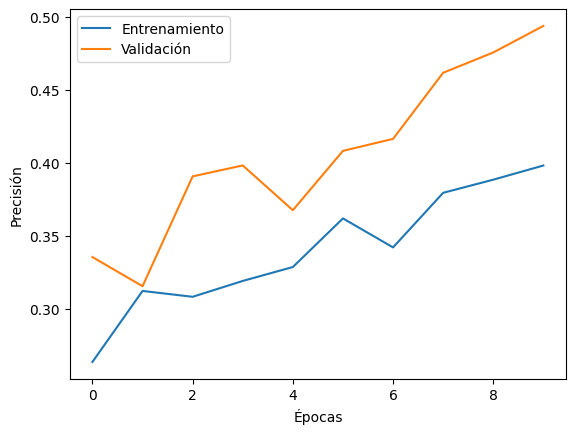

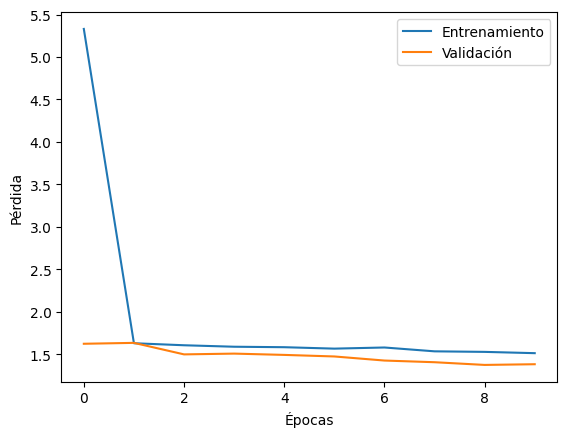

In [15]:
# Graficamos la precisión de MLP
plot_history_result(history_MLP)

#### Observaciones:
* **Entrenamiento:** El entrenamiento del modelo MLP mostró un progreso gradual, comenzando en un 0.2638 y alcanzando el 0.3983 pero el incremento es relativamente lento y arrancando desde una métrica muy baja, esto nos indica que el modelo tiene dificultades para aprender a categorizar nuestras imagenes.

* **En el conjunto de validación:** La precisión inicial fue de 0.3356, llegando a 0.4939 en la última época. El loss en validation muestra una tendencia a disminuir, lo cual nos da un indicio que el modelo va mejorando ligeramente en su capacidad de generalización.

* **Posible subajuste:** Dado los los valores bajos presentados para el accuracy podemos decir que el modelo presenta underfittig. Esto podría deberse a la falta de capacidad del modelo para este tipo de tarea ya que es uno de los más simples.

# ResNet-101
#### Dense: 500, Dropout: 0.25

In [20]:
model_ResNet = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
model_ResNet.trainable = False

x = Flatten()(model_ResNet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_ResNet101 = Model(inputs=model_ResNet.input, outputs=output)
model_ResNet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_ResNet101 = model_ResNet101.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 440s 1s/step - loss: 1.5727 - accuracy: 0.3301 - val_loss: 1.2849 - val_accuracy: 0.4795
Epoch 2/10
350/350 [==============================] - 434s 1s/step - loss: 1.3604 - accuracy: 0.4004 - val_loss: 1.2216 - val_accuracy: 0.4677
Epoch 3/10
350/350 [==============================] - 453s 1s/step - loss: 1.3202 - accuracy: 0.4273 - val_loss: 1.1690 - val_accuracy: 0.5065
Epoch 4/10
350/350 [==============================] - 441s 1s/step - loss: 1.3072 - accuracy: 0.4275 - val_loss: 1.1337 - val_accuracy: 0.5251
Epoch 5/10
350/350 [==============================] - 441s 1s/step - loss: 1.2939 - accuracy: 0.4389 - val_loss: 1.1282 - val_accuracy: 0.5345
Epoch 6/10
350/350 [==============================] - 441s 1s/step - loss: 1.2943 - accuracy: 0.4336 - val_loss: 1.0953 - val_accuracy: 0.5639
Epoch 7/10
350/350 [==============================] - 441s 1s/step - loss: 1.2687 - accuracy: 0.4519 - val_loss: 1.1143 - val_accuracy: 0.5514

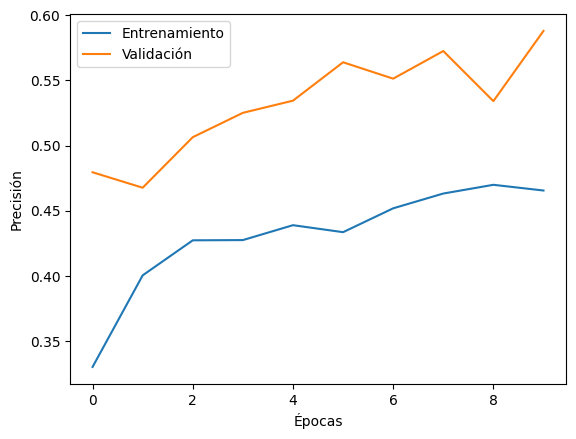

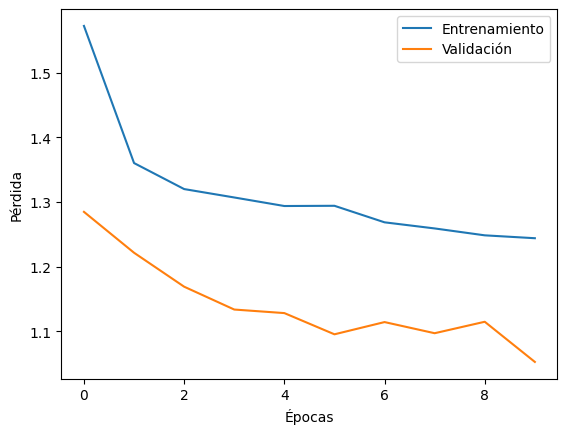

In [22]:
# Graficamos la precisión de ResNet101
plot_history_result(history_ResNet101)

#### Observaciones:
* **Entrenamiento:** Del gráfico podemos inferir que el modelo mejora época tras época, llegando al mejor valor de accuracy = 0.4699 en la época 9. Cada época duró aproximamente 7. Por  

* **En el conjunto de validación:** La precisión inicial fue de 0.4677, llegando a 0.5880 en la última época. El loss en validation va disminuyendo, lo cual nos da un indicio que el modelo va mejorando ligeramente en su capacidad de generalización teniendo margen para continuar mejorando si se entrena más épocas.

* **Posible subajuste:** Observando el gráfico podemos decir que el modelo no estar overfiteando.

# VGG19
#### Dense: 128, Dropout: 0.25

In [19]:
model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
model_VGG19.trainable = False

x = Flatten()(model_VGG19.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_VGG19_025dropout = Model(inputs=model_VGG19.input, outputs=output)
model_VGG19_025dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_VGG19 = model_VGG19_025dropout.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30
)

Epoch 1/30
351/351 [==============================] - 610s 2s/step - loss: 0.7345 - accuracy: 0.7191 - val_loss: 0.4293 - val_accuracy: 0.8470
Epoch 2/30
351/351 [==============================] - 617s 2s/step - loss: 0.5826 - accuracy: 0.7831 - val_loss: 0.4204 - val_accuracy: 0.8356
Epoch 3/30
351/351 [==============================] - 488s 1s/step - loss: 0.5488 - accuracy: 0.7935 - val_loss: 0.4037 - val_accuracy: 0.8491
Epoch 4/30
351/351 [==============================] - 474s 1s/step - loss: 0.5202 - accuracy: 0.8101 - val_loss: 0.4068 - val_accuracy: 0.8509
Epoch 5/30
351/351 [==============================] - 475s 1s/step - loss: 0.5069 - accuracy: 0.8120 - val_loss: 0.4070 - val_accuracy: 0.8427
Epoch 6/30
351/351 [==============================] - 472s 1s/step - loss: 0.4926 - accuracy: 0.8175 - val_loss: 0.3882 - val_accuracy: 0.8602
Epoch 7/30
351/351 [==============================] - 471s 1s/step - loss: 0.4794 - accuracy: 0.8198 - val_loss: 0.3919 - val_accuracy: 0.8456

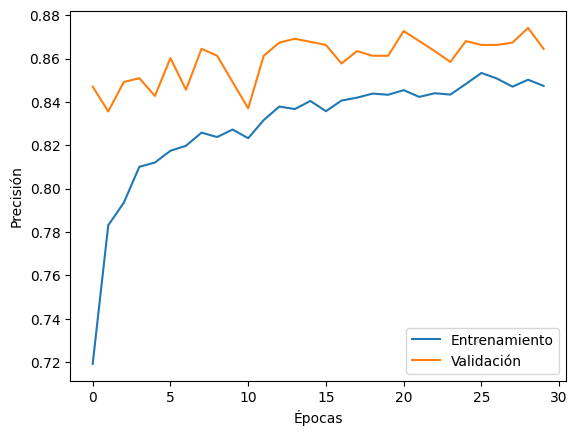

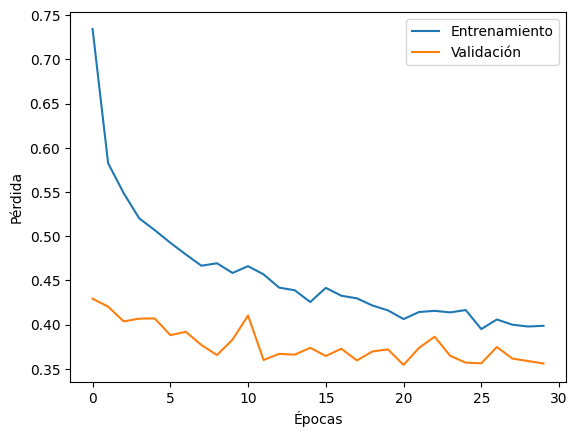

In [21]:
# Graficamos la precisión de VGG19
plot_history_result(history_VGG19)

#### Observaciones:
* **Entrenamiento:** Se alcanzó una precisión de entrenamiento del 0.7191 en la primera época, mejorando gradualmente hasta el 0.8474 al final pero siendo mejor la época 26 con 0.8533. En el conjunto de validación, la precisión inicial fue del 0.8470, y se mantuvo relativamente estable, alcanzando un máximo de 0.8727 en la época 21.

* **Generalización:** La precisión de validación se mantiene alta y sin tanta fluctuación y con una pérdida relativamente baja en las últimas épocas, lo cual podemos decir que el modelo no va a mejorar mucho mas.

# InceptionV3
#### Dense: 256, Dropout: 0.25

In [8]:
model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3.trainable = False

x = Flatten()(model_InceptionV3.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_InceptionV3 = Model(inputs=model_InceptionV3.input, outputs=output)
model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_model_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30
)

Epoch 1/30
350/350 [==============================] - 120s 335ms/step - loss: 0.8889 - accuracy: 0.7659 - val_loss: 0.3758 - val_accuracy: 0.8588
Epoch 2/30
350/350 [==============================] - 114s 326ms/step - loss: 0.5244 - accuracy: 0.8109 - val_loss: 0.3742 - val_accuracy: 0.8556
Epoch 3/30
350/350 [==============================] - 115s 327ms/step - loss: 0.4937 - accuracy: 0.8233 - val_loss: 0.3406 - val_accuracy: 0.8754
Epoch 4/30
350/350 [==============================] - 112s 320ms/step - loss: 0.4596 - accuracy: 0.8339 - val_loss: 0.3575 - val_accuracy: 0.8696
Epoch 5/30
350/350 [==============================] - 115s 328ms/step - loss: 0.4449 - accuracy: 0.8376 - val_loss: 0.3230 - val_accuracy: 0.8851
Epoch 6/30
350/350 [==============================] - 124s 354ms/step - loss: 0.4407 - accuracy: 0.8367 - val_loss: 0.3241 - val_accuracy: 0.8836
Epoch 7/30
350/350 [==============================] - 118s 336ms/step - loss: 0.4360 - accuracy: 0.8428 - val_loss: 0.3251 -

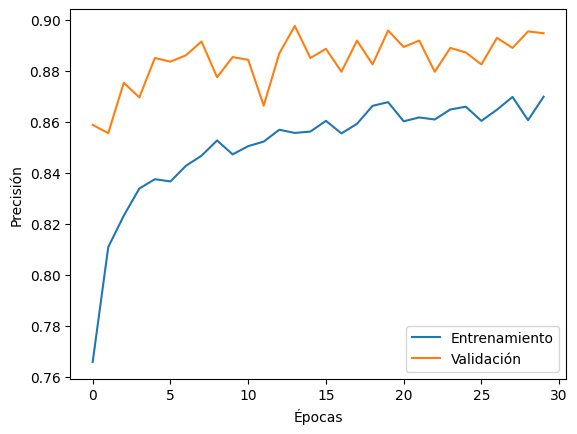

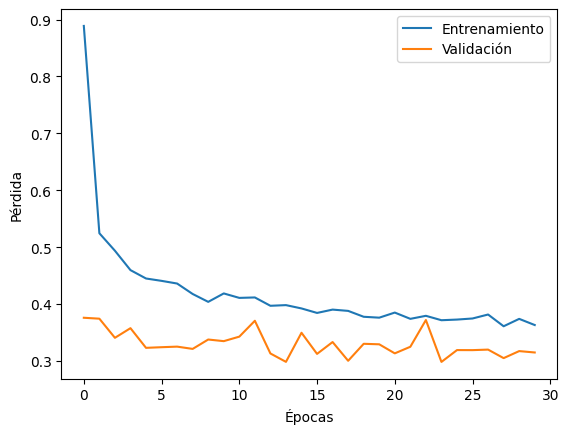

In [13]:
# Graficamos la precisión de InceptionV3_dense256_dropout025
plot_history_result(history_model_InceptionV3)

#### Observaciones:
* **Precisión:** En el conjunto de validación con InceptionV3 comienza con 0.8588 en su primer época y alcanza su punto máximo en la época 14 con una validación de 0.8976, lo que es una mejora respecto a la precisión obtenida con VGG19. La precisión final de entrenamiento también es superior.

* **Pérdida:** A diferencia de VGG19, este modelo logró una disminución más estable en la pérdida, esto nos dice que este modelo puede tener mejor performance y es el modelo a ajustar.

* **Tiempo de entrenamiento:** Este modelo es considerablemente más rápido que el de VGG19, con un tiempo promedio de 2 min por época contra los más de 7 min de VGG19, esta es otra de las razones por las cuales este modelo es mas óptimo para realizar ajsutes y pruebas para alcanzar un mejor nivel de validación.

# InceptionV3
#### Dense: 512, Dropout: 0.25, Dense: 256, Dense: 128

In [15]:
model_InceptionV3_3layers = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3_3layers.trainable = False

x = Flatten()(model_InceptionV3_3layers.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_InceptionV3_3layers = Model(inputs=model_InceptionV3_3layers.input, outputs=output)
model_InceptionV3_3layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history_model_InceptionV3_3layers = model_InceptionV3_3layers.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20
)

Epoch 1/20
351/351 [==============================] - 123s 345ms/step - loss: 1.0567 - accuracy: 0.7073 - val_loss: 0.4997 - val_accuracy: 0.8156
Epoch 2/20
351/351 [==============================] - 119s 339ms/step - loss: 0.5729 - accuracy: 0.8093 - val_loss: 0.3733 - val_accuracy: 0.8670
Epoch 3/20
351/351 [==============================] - 120s 343ms/step - loss: 0.5280 - accuracy: 0.8197 - val_loss: 0.4000 - val_accuracy: 0.8595
Epoch 4/20
351/351 [==============================] - 120s 342ms/step - loss: 0.4956 - accuracy: 0.8332 - val_loss: 0.3525 - val_accuracy: 0.8780
Epoch 5/20
351/351 [==============================] - 118s 337ms/step - loss: 0.4815 - accuracy: 0.8329 - val_loss: 0.3586 - val_accuracy: 0.8802
Epoch 6/20
351/351 [==============================] - 120s 341ms/step - loss: 0.4444 - accuracy: 0.8446 - val_loss: 0.3288 - val_accuracy: 0.8898
Epoch 7/20
351/351 [==============================] - 120s 341ms/step - loss: 0.4549 - accuracy: 0.8431 - val_loss: 0.3433 -

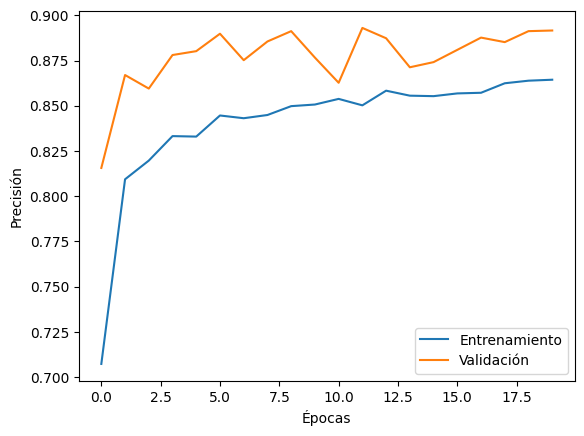

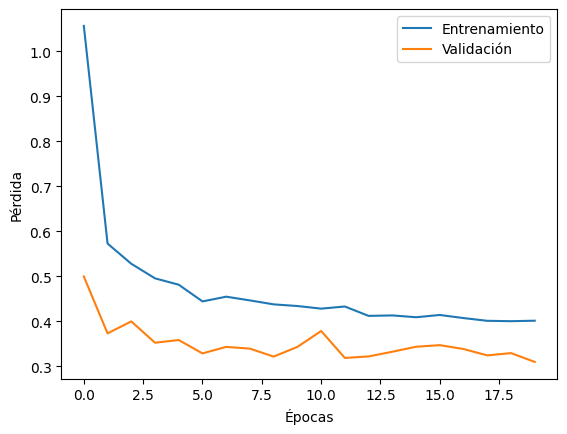

In [19]:
# Graficamos la precisión de InceptionV3_3layers
plot_history_result(history_model_InceptionV3_3layers)

#### Observaciones
* **Precisión y pérdida:** El conjunto de precisión en la primer época es de 0.7073 alcanzando un mejor resultado en la última época con 0.8644. Sobre el conjunto de validación se ve que alcanzó un valor de 0.8930 en la época 12 como mejor valor y la pérdida se reduce a 0.3099 en la última época.

* **Capas:** Las capas adicionales de 512, 256 y 128 unidades, junto con Dropout (0.25), no mostraron una mejora de rendimiento respecto al modelo anterior que una sola capa, lo que podemos concluir que agregar capas no es lo ideal para este modelo o caso particular.

* **Tiempo de entrenamiento:** A pesar de agregar capas adicionales, el tiempo por época sigue siendo similar al modelo InceptionV3 anterior (alrededor de 2 min), lo que nos permite seguir configurando el modelo para obtener mejores resultados.

# InceptionV3
#### Dense: 512, BatchNormalization(), Dropout: 0.25, Learning rate: 0.00001

In [9]:
model_InceptionV3_learning_rate = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3_learning_rate.trainable = True
for layer in model_InceptionV3_learning_rate.layers[:-20]:
    layer.trainable = False

x = Flatten()(model_InceptionV3_learning_rate.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

optimizer_fine = Adam(learning_rate=0.00001)
model_InceptionV3_learning_rate = Model(inputs=model_InceptionV3_learning_rate.input, outputs=output)
model_InceptionV3_learning_rate.compile(optimizer=optimizer_fine, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history_model_InceptionV3_learning_rate = model_InceptionV3_learning_rate.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=40
)

Epoch 1/40
351/351 [==============================] - 146s 408ms/step - loss: 0.8200 - accuracy: 0.7201 - val_loss: 0.4264 - val_accuracy: 0.8602
Epoch 2/40
351/351 [==============================] - 144s 412ms/step - loss: 0.5494 - accuracy: 0.8159 - val_loss: 0.3907 - val_accuracy: 0.8695
Epoch 3/40
351/351 [==============================] - 145s 414ms/step - loss: 0.4906 - accuracy: 0.8309 - val_loss: 0.3494 - val_accuracy: 0.8773
Epoch 4/40
351/351 [==============================] - 137s 390ms/step - loss: 0.4688 - accuracy: 0.8331 - val_loss: 0.3428 - val_accuracy: 0.8777
Epoch 5/40
351/351 [==============================] - 134s 381ms/step - loss: 0.4232 - accuracy: 0.8529 - val_loss: 0.3428 - val_accuracy: 0.8812
Epoch 6/40
351/351 [==============================] - 137s 389ms/step - loss: 0.4252 - accuracy: 0.8524 - val_loss: 0.3337 - val_accuracy: 0.8891
Epoch 7/40
351/351 [==============================] - 155s 440ms/step - loss: 0.3858 - accuracy: 0.8613 - val_loss: 0.3180 -

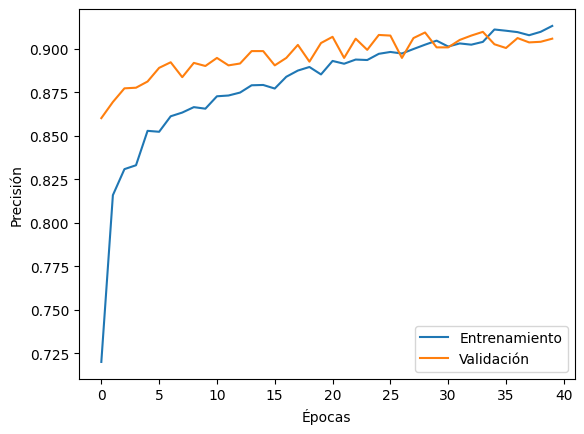

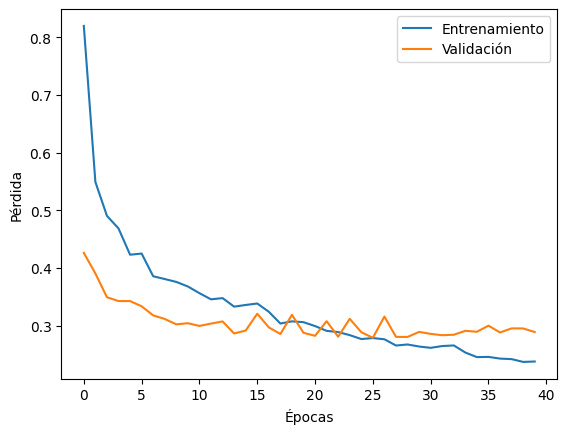

In [11]:
# Graficamos la precisión de InceptionV3_learning_rate
plot_history_result(history_model_InceptionV3_learning_rate)

#### Observaciones
* **Entrenamiento:** Este modelo en el conjunto de validación comenzó con un 0.8602 y obtuvo su mejor resultado en la época 34 con un valor de 0.9098, mientras que la pérdida en el fluctua durante todo el entrenamiento.

* **Capas:** Al volver a utilizar una sola capa pero ahora con una densidad mayor notamos un cambios faborable a la hora de entrenar el modelo, ademas descongelamos todas las capas menos las ultimas 20 para que se afinen a nuestro problema, otro adicional es que agregamos al Adam un Learning Rate de 0.00001 para estabilizar el aprendizaje lo que suguiere que si seguimos modificando esa configuracion podriamos mejorar el resultado.

* **Tiempo de entrenamiento:** En comparación al modelo multicapa hay un leve aumento de tiempos entre capas (aproximadamente 20 seg/capa), no es un tiempo considerablemente alto teniendo en cuenta que tenemos 40 épocas, pero si habria que tenerlo en cuenta para evaluaciones con épocas mayores a 70. Si se quisieran reducir los tiempos entre épocas se recomienda conseguir mejor hardware (GPU).

In [12]:
get_csv(img_folder_test, model_InceptionV3_learning_rate, 'model_InceptionV3_learning_rate')

94/94 [==============================] - 23s 233ms/step
Predicciones guardadas en 'model_InceptionV3_learning_rate.csv'


# Conclusiones:

Inicialmente, entrenamos una red CNN y luego MLP decidiendo la cantidad de capas y su densidad. Si bien fueron mejorando en las épocas que fueron entrenandos, la búsqueda de una arquitectura óptima resulta una tarea compleja ya que probamos muchas modificaciones sin resultados favorables.
Como vimos que armar arquitecturas a prueba y error no era una solución viable, decidimos aplicar tecnicas como la de *Transfer Learning* e implementamos ResNet-101 con resultados levemente mejores que los modelos anteriores por lo que decidimos seguir implementando otros modelos. El próximo modelo fue VGG19 con diferentes configuraciones lo cual resulto en un incremento notable de rendimiento (0.8680) a costa de mucho tiempo de entrenamiento por lo que decidimos probar con otra red neuronal.
Finalmente entrenamos InceptionV3 con las siguientes configuraciones:
* Densidad: 256, Activacion: relu, Dropout: 0.25.
* Multicapa = &nbsp;&nbsp;  
[Desidad: 512, Activacion: relu, Dropout: 0.25], &nbsp;&nbsp;  
                [Desidad: 256, Activacion: relu, Dropout: 0.25], &nbsp;&nbsp;  
                [Desidad: 128, Activacion: relu, Dropout: 0.25]&nbsp;&nbsp;  

* Densidad: 512, Dropout: 0.25, Descongelamos las primeras capas, excepto las ultimas 20 y utilizamos Learning Rate de 0.00001 al optimizador Adam

Con estas configuraciones de InceptionV3 vimos mejoras considerables tanto en rendimiento como en tiempos. Con la última configuración tuvimos el mejor resultado de conjunto de evaluación de 0.9098 y en la competencia en Kaggle logramos un accuracy de 0.91672.